In [1]:
import random
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import learn2learn as l2l
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
# The corase reconstruction is the rss of the zerofilled multi-coil kspaces
# after inverse FT.
from functions.data.transforms import UnetDataTransform, UnetDataTransform_norm, normalize
# Import a torch.utils.data.Dataset class that takes a list of data examples, a path to those examples
# a data transform and outputs a torch dataset.
from functions.data.mri_dataset import SliceDataset
# Unet architecture as nn.Module
from functions.models.unet import Unet
# Function that returns a MaskFunc object either for generatig random or equispaced masks
from functions.data.subsample import create_mask_for_mask_type
# Implementation of SSIMLoss
from functions.training.losses import SSIMLoss

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

####################################################################################
SEED = 1
INIT = 'TEST'   # 'standard', 'maml'
TARGET = 'Q1'       # 'Q1', 'Q2', 'Q3'
LR = 0.001 


# hyperparameter
TRAINING_EPOCH = 30
adapt_shot = 10

####################################################################################
# seed
random.seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

# different trained weight
if INIT == 'standard':
    checkpoint_path = "/cheng/metaMRI/metaMRI/save/E6*/E6.6_standard(NMSE-lrAnneal)_T8x200_100epoch_E85_best.pth"
elif INIT == 'maml':
    checkpoint_path = "/cheng/metaMRI/metaMRI/save/E6*/E6.4_maml(NMSE-lre-3)_T8x200_200epoch_E200_best.pth"
elif INIT == 'TEST':
    checkpoint_path = "/cheng/metaMRI/metaMRI/save/11E6.9_maml(NMSE-lrAnneal)_T8x200_200epoch/E6.9_maml(NMSE-lrAnneal)_T8x200_200epoch_E166.pth"
else: 
    print('Choose the initialization weight. ')

# target domain
if TARGET == 'Q1': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_train_AXT1POST_TrioTim_5-8.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXT1POST_TrioTim_5-8.yaml'
elif TARGET == 'Q2': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_train_AXFLAIR_Skyra_5-8.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXFLAIR_Skyra_5-8.yaml'
elif TARGET == 'Q3': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_train_AXT2_Aera_5-8.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.2/brain_test_AXT2_Aera_5-8.yaml'
elif TARGET == 'P1': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PD_Aera_2-9.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PD_Aera_2-9.yaml'
elif TARGET == 'P2': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PD_Aera_15-22.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PD_Aera_15-22.yaml'
elif TARGET == 'P3': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PD_Biograph_15-22.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PD_Biograph_15-22.yaml'
elif TARGET == 'P4': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PD_Skyra_15-22.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PD_Skyra_15-22.yaml'
elif TARGET == 'P5': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PDFS_Aera_2-9.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PDFS_Aera_2-9.yaml'
elif TARGET == 'P6': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PDFS_Aera_15-22.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PDFS_Aera_15-22.yaml'
elif TARGET == 'P7': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PDFS_Biograph_15-22.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PDFS_Biograph_15-22.yaml'
elif TARGET == 'P8': 
    path_adapt = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_val_PDFS_Skyra_15-22.yaml'
    path_test = '/cheng/metaMRI/metaMRI/data_dict/E6.3/P/knee_test_PDFS_Skyra_15-22.yaml'


Data

In [2]:
# mask function and data transform
mask_function = create_mask_for_mask_type(mask_type_str = 'random', self_sup = False, 
                    center_fraction = 0.08, acceleration = 4.0, acceleration_total = 3.0)


data_transform = UnetDataTransform_norm('multicoil', mask_func = mask_function, use_seed=True, mode='adapt')

sourse_set = SliceDataset(dataset = path_adapt, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                        challenge="multicoil", transform=data_transform, use_dataset_cache=True)
indices = random.sample(range(len(sourse_set)), adapt_shot)
# adapt_shot_sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
adapt_dataset = torch.utils.data.Subset(sourse_set, indices)
adapt_dataloader = torch.utils.data.DataLoader(adapt_dataset, batch_size = 1, num_workers = 8, 
                                generator = torch.Generator().manual_seed(1), pin_memory = True)

print("Adapt date number: ", len(adapt_dataloader))
#%%

test_set = SliceDataset(dataset = path_test, path_to_dataset='', path_to_sensmaps=None, provide_senmaps=False, 
                      challenge="multicoil", transform=data_transform, use_dataset_cache=True)
print("Validation date number: ", len(test_set))

# dataloader: batch size 1 
test_dataloader = torch.utils.data.DataLoader(dataset = test_set, batch_size = 1, num_workers = 8, 
                    shuffle = False, generator = torch.Generator().manual_seed(1))

Adapt date number:  10
Validation date number:  132


Model

In [3]:
model = Unet(in_chans=1, out_chans=1, chans=32, num_pool_layers=4, drop_prob=0.0)
model.load_state_dict(torch.load(checkpoint_path))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(),lr=LR)

### Calculate the early-stopping epoch as a hyperparameter

In [4]:
def evaluate(model, dataloader):
    model.eval()
    total_l1_loss = 0.0
    total_ssim_loss = 0.0
    total_psnr_loss = 0.0
    total_nmse_loss = 0.0
    l1_loss = torch.nn.L1Loss(reduction='sum')
    ssim_fct = SSIMLoss()
    psner_mse_fct = torch.nn.MSELoss(reduction='mean')
    mse_fct = torch.nn.MSELoss(reduction='sum')

    for iter, batch in enumerate(dataloader): 
        input_image, target_image, mean, std, fname, slice_num = batch
        val_inputs = input_image.to(device)
        val_targets = target_image.to(device)
        std = std.to(device)
        mean = mean.to(device)

        val_outputs = model(val_inputs)
        val_outputs = val_outputs * std + mean

        # NMAE
        l1 = l1_loss(val_outputs, val_targets) / torch.sum(torch.abs(val_targets))
        total_l1_loss += l1.item()
        # NMSE 
        nmse_loss = mse_fct(val_outputs, val_targets) / torch.sum(torch.abs(val_targets)**2)
        total_nmse_loss += nmse_loss.item()
        # PSNR
        psnr_loss = 20*torch.log10(torch.tensor(val_targets.max().unsqueeze(0).item()))-10*torch.log10(psner_mse_fct(val_outputs,val_targets))
        total_psnr_loss += psnr_loss.item()
        # SSIM = 1 - loss
        ssim_loss = ssim_fct(val_outputs, val_targets, data_range = val_targets.max().unsqueeze(0))
        total_ssim_loss += (1-ssim_loss.item())

    validation_loss_l1 = total_l1_loss / len(dataloader) 
    validation_loss_NMSE = total_nmse_loss / len(dataloader)
    validation_loss_PSNR = total_psnr_loss / len(dataloader)
    validation_loss_SSIM = total_ssim_loss / len(dataloader)

    return validation_loss_l1, validation_loss_NMSE, validation_loss_PSNR, validation_loss_SSIM

In [5]:
# for one sampled specific few-shots
def cal_early_stopping(model, checkpoint_path, dataset, training_epoch, split_ratio):
    # init the model
    model.load_state_dict(torch.load(checkpoint_path))
    model.train()
    # Split the val data for early stop
    train_dataset, val_dataset = torch.utils.data.random_split(list(dataset), split_ratio)

    train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 1,  
                        shuffle = False, generator = torch.Generator().manual_seed(1))
    val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = 1,
                        shuffle = False, generator = torch.Generator().manual_seed(1))
    val_loss_history = []
    for i in tqdm(range(training_epoch)):    
        #print('Iteration:', iteration+1)
        # train on 5-shots
        mse_fct = torch.nn.MSELoss(reduction='sum')

        for iter, batch in enumerate(train_loader):
            input_image, target_image, mean, std, fname, slice_num = batch
            train_inputs = input_image.to(device)
            train_targets = target_image.to(device)
            std = std.to(device)
            mean = mean.to(device)

            train_outputs = model(train_inputs)
            train_outputs = train_outputs * std + mean

            loss = mse_fct(train_outputs, train_targets) / torch.sum(torch.abs(train_targets)**2)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # evaluate on another 5-shots
        validation_loss_l1, validation_loss_NMSE, validation_loss_PSNR, validation_loss_SSIM = evaluate(model, val_loader)
        val_loss_history.append(validation_loss_NMSE)

        # init the min value and index
        min_value = val_loss_history[0] 
        min_index = 0     
        for i in range(1, len(val_loss_history)):
            if val_loss_history[i] < min_value:
                min_value = val_loss_history[i]
                min_index = i 

    return min_index

def average_early_stopping_epoch(model, checkpoint_path, dataset, training_epoch=30, split_ratio=[7,3], repeat_times=5): 
    # repeat several times and get the average early-stopping epoch
    min_index_history = []
    for i in range(repeat_times):
        min_index = cal_early_stopping(model, checkpoint_path, dataset, training_epoch, split_ratio)
        min_index_history.append(min_index)

    min_index_mean = sum(min_index_history) / len(min_index_history) 
    suggest_epoch = round(min_index_mean)+1
    return suggest_epoch

100%|██████████| 30/30 [00:04<00:00,  6.13it/s]


Suggested early-stopping epoch

In [7]:
suggest_epoch = average_early_stopping_epoch(model, checkpoint_path, adapt_dataset, training_epoch=30, split_ratio=[7,3], repeat_times=5)
print('The early-stopping epoch: ', suggest_epoch)

The early-stopping epoch:  7


### Adaptation

In [8]:
def adapt(model, dataloader, optimizer): 
    model.train()
    train_loss = 0.0
    mse_fct = torch.nn.MSELoss(reduction='sum')

    for iter, batch in enumerate(dataloader):
        input_image, target_image, mean, std, fname, slice_num = batch
        train_inputs = input_image.to(device)
        train_targets = target_image.to(device)
        std = std.to(device)
        mean = mean.to(device)

        train_outputs = model(train_inputs)
        train_outputs = train_outputs * std + mean

        loss = mse_fct(train_outputs, train_targets) / torch.sum(torch.abs(train_targets)**2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(dataloader)
    return avg_train_loss

##########################
# init the model
model.load_state_dict(torch.load(checkpoint_path))

train_loss_history = []
test_loss_history_NMSE = []
test_loss_history_PSNR = []
test_loss_history_SSIM = []
test_loss_l1, test_loss_NMSE, test_loss_PSNR, test_loss_SSIM = evaluate(model, test_dataloader)
test_loss_history_NMSE.append(test_loss_NMSE)
test_loss_history_PSNR.append(test_loss_PSNR)
test_loss_history_SSIM.append(test_loss_SSIM)
for iteration in tqdm(range(TRAINING_EPOCH)):
    # print('Iteration:', iteration+1)
    # training
    training_loss = adapt(model, adapt_dataloader, optimizer)
    train_loss_history.append(training_loss)
    # val
    test_loss_l1, test_loss_NMSE, test_loss_PSNR, test_loss_SSIM = evaluate(model, test_dataloader)
    test_loss_history_NMSE.append(test_loss_NMSE)
    test_loss_history_PSNR.append(test_loss_PSNR)
    test_loss_history_SSIM.append(test_loss_SSIM)


100%|██████████| 30/30 [01:38<00:00,  3.29s/it]


In [9]:
print('The initial performance: ')
print('NMSE: ', test_loss_history_NMSE[0])
print('PSNR: ', test_loss_history_PSNR[0])
print('SSIM: ', test_loss_history_SSIM[0])

The initial performance: 
NMSE:  0.018237841372011288
PSNR:  30.766176368250992
SSIM:  0.8137275057308602


In [10]:
print('The performance by early-stopping: ')
print('NMSE: ', test_loss_history_NMSE[round(min_index_mean)+1])
print('PSNR: ', test_loss_history_PSNR[round(min_index_mean)+1])
print('SSIM: ', test_loss_history_SSIM[round(min_index_mean)+1])

The performance by early-stopping: 
NMSE:  0.011848835627350843
PSNR:  32.63725780718254
SSIM:  0.8961519197081075


In [14]:
# b = 14
# print('NMSE: ', test_loss_history_NMSE[b])
# print('PSNR: ', test_loss_history_PSNR[b])
# print('SSIM: ', test_loss_history_SSIM[b])

### Plot figures

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    })

colors = [(0.2298057,0.298717966,0.753683153),
          (0.3634607953411765,0.4847836818509804,0.9010188868941177),
          (0.5108243242509803,0.6493966148235294,0.9850787763764707),
          (0.6672529243333334,0.7791764569999999,0.992959213),
          (0.8049647588235295,0.8516661605568627,0.9261650744313725),
          (0.9193759889058823,0.8312727235294118,0.7828736304470588),
          (0.968203399,0.7208441,0.6122929913333334),
          (0.9440545734235294,0.5531534787490197,0.4355484903137255),
          (0.8523781350078431,0.34649194649411763,0.2803464686980392),
          (0.705673158,0.01555616,0.150232812)]
colors = ['b','r','k','g','m','c','tab:brown','tab:orange','tab:pink','tab:gray','tab:olive','tab:purple']

markers = ["v","o","^","1","*",">","d","<","s","P","X"]
FONTSIZE = 22


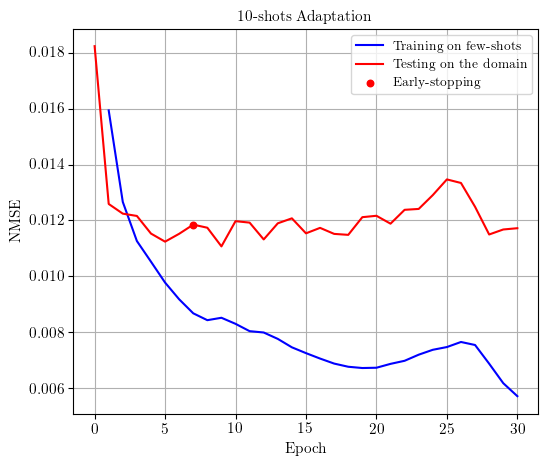

In [12]:
plt.figure(figsize=(6,5))# ,dpi=300
plt.plot(range(1, 31), train_loss_history, color=colors[0], label='Training on few-shots')
plt.plot(range(0, 31), test_loss_history_NMSE, color=colors[1], label='Testing on the domain')
plt.scatter(suggest_epoch, test_loss_history_NMSE[suggest_epoch], color=colors[1], s=FONTSIZE, label = 'Early-stopping')
plt.legend(fontsize = (FONTSIZE-3)/2)
plt.title('10-shots Adaptation', fontsize = FONTSIZE/2)
#plt.yticks(np.arange(0, 0.5, 0.1))
plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epoch',fontsize=FONTSIZE/2)
plt.ylabel('NMSE',fontsize=FONTSIZE/2)
plt.grid(True)
# plt.savefig('save/plots/fasterrcnn_v2.png', format='png', bbox_inches='tight')

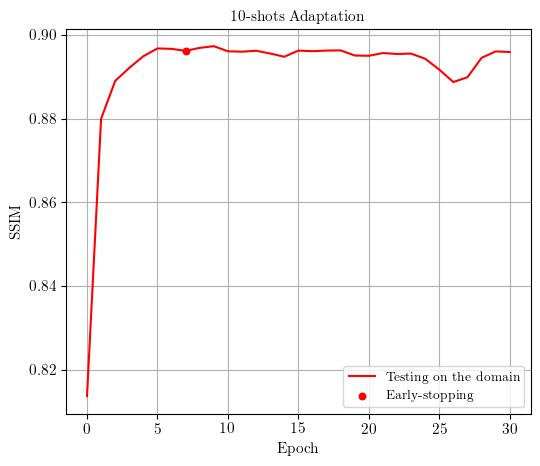

In [13]:
plt.figure(figsize=(6,5))
plt.plot(range(0, 31), test_loss_history_SSIM, color=colors[1], label='Testing on the domain')
plt.scatter(round(min_index_mean)+1, test_loss_history_SSIM[round(min_index_mean)+1], color=colors[1], s=FONTSIZE, label = 'Early-stopping')
plt.legend(fontsize = (FONTSIZE-3)/2)
plt.title('10-shots Adaptation', fontsize = FONTSIZE/2)
#plt.yticks(np.arange(0, 0.5, 0.1))
plt.tick_params(axis='both', which='major', labelsize=FONTSIZE/2)
plt.tick_params(axis='both', which='minor', labelsize=(FONTSIZE-2)/2)
plt.xlabel('Epoch',fontsize=FONTSIZE/2)
plt.ylabel('SSIM',fontsize=FONTSIZE/2)
plt.grid(True)
# plt.savefig('save/plots/fasterrcnn_v2.png', format='png', bbox_inches='tight')